# Logistic regression with Tensorflow Probability

In [ ]:
############ EJECUTAR EN COLAB

In [1]:
# !pip install tensorflow

In [2]:
# !pip install tensorflow_probability

## 0. Setup

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import arviz as az

## 1. Binary univariate classification

In [9]:
N = 50
K=1

In [10]:
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,2.250242,4.080313
1,2.134951,5.379464
2,2.613353,3.624561
3,3.293855,3.793791
4,0.570037,4.610247


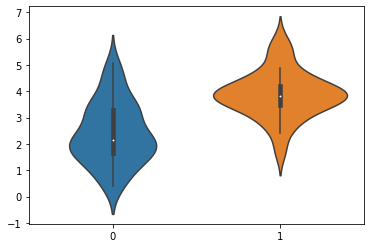

In [11]:
sns.violinplot(data=data)
plt.show()

In [12]:
x_0_ = np.concatenate([x1, x2]).reshape((2*N, 1))
y_0_ = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [14]:
# https://github.com/dhxoghks95/oh_blog/blob/356ef67afc569511bc83f30f9a0875292d02de17/content/challenger.md

def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)

In [15]:
x_0 = tf.convert_to_tensor(x_0_, dtype=tf.float32)
y_0 = tf.convert_to_tensor(y_0_, dtype=tf.float32)

tfd = tfp.distributions
# loc = mu, scale = sigma
alpha = tfd.Normal(name="alpha", loc=0, scale=10).sample()
beta = tfd.Normal(name="beta", loc=0, scale=10).sample()

mu = alpha + beta * x_0_

theta_deterministic = tfd.Deterministic(name="theta", loc=1.0/(1. + tf.exp(-mu))).sample()

[
    prior_alpha_,
    prior_beta_,
    theta_deterministic_,
    y_0_,
] = evaluate([
    alpha,
    beta,
    theta_deterministic,
    y_0,
])

In [16]:
# likelihood

def challenger_joint_log_prob(y_0, x_0_, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      D: The Data from the challenger disaster representing presence or 
         absence of defect
      temperature_: The Data from the challenger disaster, specifically the temperature on 
         the days of the observation of the presence or absence of a defect
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = tfd.Normal(loc=0., scale=10)
    rv_beta = tfd.Normal(loc=0., scale=10)
    # logistic_p = 1.0/(1. + tf.exp(beta * tf.to_float(x) + alpha))
    logistic_p = 1.0/(1. + tf.exp(beta * x_0_ + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
  
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(y_0))
    )

In [21]:
number_of_steps = 10000
burnin = 2000

# Set the chain's start state.
initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
    0. * tf.ones([], dtype=tf.float32, name="init_beta")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# Alpha is 100x of beta approximately, so apply Affine scalar bijector
# to multiply the unconstrained alpha by 100 to get back to 
# the Challenger problem space
# unconstraining_bijectors = [
#     tfp.bijectors.AffineScalar(100.),
#     tfp.bijectors.Identity()
# ]


unconstraining_bijectors = [
    tfb.Shift(0)(tfb.Scale(10.)),
    tfp.bijectors.Identity()
]

#### https://github.com/dhxoghks95/oh_blog/blob/356ef67afc569511bc83f30f9a0875292d02de17/content/challenger.md

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: challenger_joint_log_prob(y_0, x_0_, *args)

# step_size를 정의합니다.
step_size = 0.01

# HMC를 정의합니다
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=40, #to improve convergence
        step_size=step_size,
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

hmc = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=hmc, num_adaptation_steps=int(burnin * 0.8))

%%time

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables for preconditions
init_g = tf.global_variables_initializer()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


KeyboardInterrupt: ignored

In [ ]:
evaluate(init_g)
[
    posterior_alpha_,
    posterior_beta_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta,
    kernel_results
])
    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

In [ ]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [ ]:
# https://github.com/dhxoghks95/oh_blog/blob/356ef67afc569511bc83f30f9a0875292d02de17/content/challenger.md

matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from IPython.core.pylabtools import figsize

plt.figure(figsize(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color=TFColor[6], density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color=TFColor[0], density=True)
plt.legend();